In [2]:
### import libraries ###
from astropy.io import fits
from astropy import table
import os
import pandas as pd
from func_stat import statResid
import matplotlib.pyplot as plt

In [3]:
### Working directories and file names ###
dirCatalogs=r'/mnt/Data/Work/Sources/COSMOS/Catalogs/DuplicateCheck'
os.chdir(dirCatalogs)

testDuplInFileName=r"Test_MSpecOrig_duplicatesIn.csv"

In [4]:
test=pd.read_csv(testDuplInFileName)
# INTify Seq column (aka ID)
test['Seq']=test['Seq'].apply(int)
# Fix 'Infinities'
test.loc[test['specZ_outlCoeff']=='Infinity','specZ_outlCoeff']=-99.9
test['specZ_outlCoeff']=test['specZ_outlCoeff'].astype(float)
# Limit crazy spec-z
test=test[(test['z_spec']>0) & (test['z_spec']<8)]

In [5]:
# Creating a column where we calculate max difference between the measurements for every object
test['SpecScatter']=0
test['NumMeasurements']=0
# Identifying and counting objects with multiple measurements
test_uniq=test['Seq'].value_counts()
# Calculating max difference between the measurements for every object 
for i in test_uniq[test_uniq>1].index:
    diff=test.loc[test['Seq']==i,'z_spec'].max()-test.loc[test['Seq']==i,'z_spec'].min()
    test.loc[test['Seq']==i,'SpecScatter']=diff
    test.loc[test['Seq']==i,'NumMeasurements']=test_uniq[i]

In [6]:
def countOutlStat(df,case:str):
    df=df.drop_duplicates(subset='Seq')
    stat={}
    stat['Case']=case
    stat['Num_obj']=len(df)
    d=df[df['resid_ML'].abs()>=0.15]
    stat['Num_outl_ML']=len(d)
    stat['% outl_ML']=round(len(d)/len(df)*100,2)
    d=df[df['resid_SED'].abs()>=0.15]
    stat['Num_outl_SED']=len(d)
    stat['% outl_SED']=round(len(d)/len(df)*100,2)
    d=df[df['residML_SED'].abs()>=0.15]
    stat['Num_outl_ML/SED']=len(d)
    stat['% outl_ML/SED']=round(len(d)/len(df)*100,2)
    return stat

In [7]:
outlAnalysis=pd.DataFrame(columns=['Case','Num_obj',
                                   'Num_outl_ML','% outl_ML',
                                   'Num_outl_SED','% outl_SED',
                                   'Num_outl_ML/SED','% outl_ML/SED'])

t=test
outlAnalysis=outlAnalysis.append(countOutlStat(t,'Total'),ignore_index=True)

t=test[test['NumMeasurements']<=1]
outlAnalysis=outlAnalysis.append(countOutlStat(t,'Single measurement'),ignore_index=True)

t=test[test['NumMeasurements']>1]
t=t[t['SpecScatter']<0.1]
outlAnalysis=outlAnalysis.append(countOutlStat(t,'Multiple measurements, spec-z scatter <0.1'),
                                 ignore_index=True)

t=test[test['NumMeasurements']>1]
t=t[t['SpecScatter']>=0.1]
outlAnalysis=outlAnalysis.append(countOutlStat(t,'Multiple measurements, spec-z scatter >=0.1'),
                                 ignore_index=True)

In [8]:
outlAnalysis

,Case,Num_obj,Num_outl_ML,% outl_ML,Num_outl_SED,% outl_SED,Num_outl_ML/SED,% outl_ML/SED
0,Total,5967,98,1.64,133,2.23,69,1.16
1,Single measurement,3745,63,1.68,98,2.62,58,1.55
2,"Multiple measurements, spec-z scatter <0.1",1945,4,0.21,5,0.26,4,0.21
3,"Multiple measurements, spec-z scatter >=0.1",277,31,11.19,30,10.83,7,2.53


In [9]:
t=test.drop_duplicates('Seq')
t=t[t['NumMeasurements']>1]
t=t[t['SpecScatter']<0.1]
print(statResid(t,'resid_ML'))
print(statResid(t,'resid_SED'))

{'Num objects': 1945, 'Std': 0.024, 'NMAD': 0.017, 'Mean': 0.0017, '% outl_15': 0.21}
{'Num objects': 1945, 'Std': 0.056, 'NMAD': 0.009, 'Mean': 0.0015, '% outl_15': 0.26}


In [10]:
t=test.drop_duplicates('Seq')
t=t[t['NumMeasurements']==0]
#t=t[t['SpecScatter']<0.1]
print(statResid(t,'resid_ML'))
print(statResid(t,'resid_SED'))

{'Num objects': 3745, 'Std': 0.048, 'NMAD': 0.02, 'Mean': -0.0038, '% outl_15': 1.68}
{'Num objects': 3745, 'Std': 0.104, 'NMAD': 0.012, 'Mean': -0.0058, '% outl_15': 2.62}


In [11]:
outlAnalysis_outlCoeff=pd.DataFrame(columns=['Case','Num_obj',
                                   'Num_outl_ML','% outl_ML',
                                   'Num_outl_SED','% outl_SED',
                                   'Num_outl_ML/SED','% outl_ML/SED'])
t=test
t=t[t['specZ_outlCoeff'].abs()<=1]

outlAnalysis_outlCoeff=outlAnalysis_outlCoeff.append(countOutlStat(t,'Total'),ignore_index=True)

t=test[test['NumMeasurements']<=1]
t=t[t['specZ_outlCoeff'].abs()<=1]
outlAnalysis_outlCoeff=outlAnalysis_outlCoeff.append(countOutlStat(t,'Single measurement'),ignore_index=True)

t=test[test['NumMeasurements']>1]
t=t[t['SpecScatter']<0.1]
t=t[t['specZ_outlCoeff'].abs()<=1]
outlAnalysis_outlCoeff=outlAnalysis_outlCoeff.append(countOutlStat(t,'Multiple measurements, spec-z scatter <0.1'),
                                 ignore_index=True)

t=test[test['NumMeasurements']>1]
t=t[t['SpecScatter']>=0.1]
t=t[t['specZ_outlCoeff'].abs()<=1]
outlAnalysis_outlCoeff=outlAnalysis_outlCoeff.append(countOutlStat(t,'Multiple measurements, spec-z scatter >=0.1'),
                                 ignore_index=True)

In [12]:
outlAnalysis

,Case,Num_obj,Num_outl_ML,% outl_ML,Num_outl_SED,% outl_SED,Num_outl_ML/SED,% outl_ML/SED
0,Total,5967,98,1.64,133,2.23,69,1.16
1,Single measurement,3745,63,1.68,98,2.62,58,1.55
2,"Multiple measurements, spec-z scatter <0.1",1945,4,0.21,5,0.26,4,0.21
3,"Multiple measurements, spec-z scatter >=0.1",277,31,11.19,30,10.83,7,2.53


In [13]:
outlAnalysis_outlCoeff

,Case,Num_obj,Num_outl_ML,% outl_ML,Num_outl_SED,% outl_SED,Num_outl_ML/SED,% outl_ML/SED
0,Total,4311,8,0.19,30,0.70,33,0.77
1,Single measurement,2683,5,0.19,24,0.89,28,1.04
2,"Multiple measurements, spec-z scatter <0.1",1468,0,0.00,1,0.07,1,0.07
3,"Multiple measurements, spec-z scatter >=0.1",160,3,1.88,5,3.12,4,2.50


In [14]:
t=test.drop_duplicates('Seq')
t=t[t['NumMeasurements']>1]
t=t[t['SpecScatter']<0.1]
t=t[t['resid_ML'].abs()>=0.15]
t['NumMeasurements']

864     2
1002    2
2524    2
4212    2
Name: NumMeasurements, dtype: int64

In [15]:
from numpy import inf
test.loc[test['specZ_outlCoeff']==-inf,'specZ_outlCoeff']=-99
t=test.drop_duplicates('Seq')

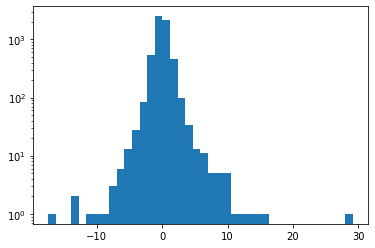

In [16]:
t=t[t['specZ_outlCoeff']>-99]
plt.hist(t['specZ_outlCoeff'],40)
plt.yscale('log')

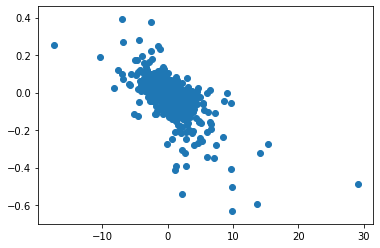

In [17]:
t=t[t['trainMapOccupation']>5]
plt.scatter(t['specZ_outlCoeff'],t['resid_ML'])

In [18]:
test.columns

Index(['RAJ2000', 'DEJ2000', 'Seq', 'Ksmagap3', 'Ymagap3', 'Hmagap3',
       'Jmagap3', 'Bmagap3', 'Vmagap3', 'ipmagap3', 'rmagap3', 'umagap3',
       'zppmagap3', 'IB574ap3', 'photoZ_SED', 'specZ', 'Instr_1', 'Q_f_1',
       'sc_Ksmagap3', 'sc_Ymagap3', 'sc_Hmagap3', 'sc_Jmagap3', 'sc_Bmagap3',
       'sc_Vmagap3', 'sc_ipmagap3', 'sc_rmagap3', 'sc_umagap3', 'sc_zppmagap3',
       'photoZ_ML', 'resid_ML', 'resid_SED', 'residML_SED', 'w_sc_Ksmagap3',
       'w_sc_Ymagap3', 'w_sc_Hmagap3', 'w_sc_Jmagap3', 'w_sc_Bmagap3',
       'w_sc_Vmagap3', 'w_sc_ipmagap3', 'w_sc_rmagap3', 'w_sc_umagap3',
       'w_sc_zppmagap3', 'quantErr', 'cellID_TrainSOM', 'cellID_RunSOM',
       'cellID_RunBigSOM', 'specZ_outlCoeff', 'photoZ_ML_outlCoeff',
       'photoZ_SED_outlCoeff', 'quantErr_outlCoeff', 'trainMapOccupation',
       'L_ID', 'Instr_2', 'ORI_RA', 'ORI_Dec', 'ORI_ID', 'z_spec', 'Q_f_2',
       'RA_corr', 'Dec_corr', 'ID', 'ALPHA_J2000', 'DELTA_J2000', 'GroupID_2',
       'GroupSize_2', 'Contact'

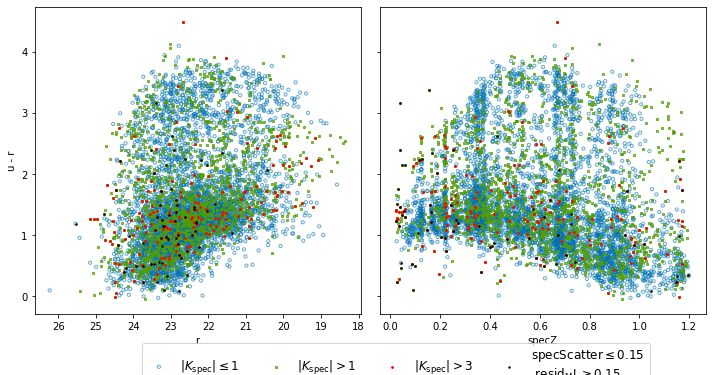

In [193]:
fig, axs = plt.subplots(1,2,figsize=(10,5),sharey='row')
colorBlindPalette=['#000000','#E69F00','#539e00','#0072B2','#D55E00','#56B4E9','#F0E442','#CC79A7']

ax0=axs[0]
ax1=axs[1]

t=test.drop_duplicates('Seq')
t=t[t['specZ_outlCoeff'].abs()<=1]
ax0.scatter(t['rmagap3'],t['umagap3']-t['rmagap3'],s=10,
            label=r'$|K_\mathrm{spec}| \leq 1$',alpha=0.6,
            marker='o',facecolors='none', edgecolors='#0072B2')
a1=ax1.scatter(t['specZ'],t['umagap3']-t['rmagap3'],s=10,
            label=r'$|K_\mathrm{spec}| \leq 1$',alpha=0.6,
            marker='o',facecolors='none', edgecolors='#0072B2')

t=test.drop_duplicates('Seq')
t=t[t['specZ_outlCoeff'].abs()>1]
ax0.scatter(t['rmagap3'],t['umagap3']-t['rmagap3'],s=3,
            c='#539e00',marker='s',label=r'$|K_\mathrm{spec}| > 1$',alpha=0.7)
a2=ax1.scatter(t['specZ'],t['umagap3']-t['rmagap3'],s=3,
            c='#539e00',marker='s',label=r'$|K_\mathrm{spec}| > 1$',alpha=0.7)

t=t[t['specZ_outlCoeff'].abs()>3]
ax0.scatter(t['rmagap3'],t['umagap3']-t['rmagap3'],s=3,c='red',label=r'$|K_\mathrm{spec}| > 3$')
a3=ax1.scatter(t['specZ'],t['umagap3']-t['rmagap3'],s=3,c='red',label=r'$|K_\mathrm{spec}| > 3$')

t=test.drop_duplicates('Seq')
t=t[t['resid_ML'].abs()>=0.15]
t=t[t['SpecScatter']<0.15]
ax0.scatter(t['rmagap3'],t['umagap3']-t['rmagap3'],s=2,
            c='black',label='$\mathrm{specScatter} \leq 0.15$ \n $\mathrm{resid_ML} \geq 0.15$')
a4=ax1.scatter(t['specZ'],t['umagap3']-t['rmagap3'],s=2,
            c='black',label='$\mathrm{specScatter} < 0.15$ \n resid_ML $\geq 0.15$')

ax0.set_xlabel('r')
ax1.set_xlabel('specZ')
ax0.set_ylabel('u - r')
ax0.invert_xaxis()

labels=(r'$|K_\mathrm{spec}| \leq 1$',r'$|K_\mathrm{spec}| > 1$',
       r'$|K_\mathrm{spec}| > 3$','$\mathrm{specScatter} \leq 0.15$ \n $\mathrm{resid_ML} \geq 0.15$')
fig.legend((a1,a2,a3,a4),labels,fontsize=12,ncol=4,loc='lower center',bbox_to_anchor=(0.55,-0.05),)
plt.tight_layout()


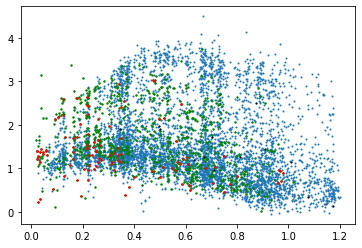

In [74]:
t=test.drop_duplicates('Seq')
t=t[t['specZ_outlCoeff']<=1]
plt.scatter(t['specZ'],t['umagap3']-t['rmagap3'],s=1)
t=test.drop_duplicates('Seq')
t=t[t['specZ_outlCoeff']>1]
plt.scatter(t['specZ'],t['umagap3']-t['rmagap3'],s=2,c='green')
t=t[t['specZ_outlCoeff']>3]
plt.scatter(t['specZ'],t['umagap3']-t['rmagap3'],s=2,c='red')
t=test.drop_duplicates('Seq')
t=t[t['SpecScatter']>0.15]
t=t[t['resid_ML']>0.15]
plt.scatter(t['specZ'],t['umagap3']-t['rmagap3'],s=1,c='black')
#plt.gca().invert_xaxis()

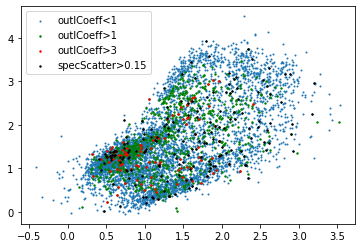

In [70]:
t=test.drop_duplicates('Seq')
t=t[t['specZ_outlCoeff']<=1]
plt.scatter(t['rmagap3']-t['Jmagap3'],t['umagap3']-t['rmagap3'],s=1,label='outlCoeff<1')
t=test.drop_duplicates('Seq')
t=t[t['specZ_outlCoeff']>1]
plt.scatter(t['rmagap3']-t['Jmagap3'],t['umagap3']-t['rmagap3'],s=2,c='green',label='outlCoeff>1')
t=t[t['specZ_outlCoeff']>3]
plt.scatter(t['rmagap3']-t['Jmagap3'],t['umagap3']-t['rmagap3'],s=2,c='red',label='outlCoeff>3')
t=test.drop_duplicates('Seq')
t=t[t['SpecScatter']>0.15]
plt.scatter(t['rmagap3']-t['Jmagap3'],t['umagap3']-t['rmagap3'],s=2,c='black',label='specScatter>0.15')
plt.legend()
#plt.gca().invert_xaxis()

(0.1, 0.2)

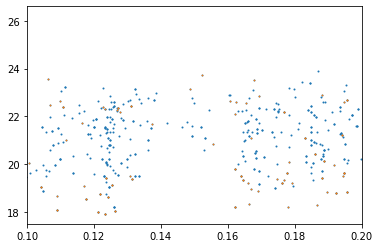

In [37]:
t=test
plt.scatter(t['specZ'],t['ipmagap3'],s=1)
t=t[t['specZ_outlCoeff']>=1]
plt.scatter(t['specZ'],t['ipmagap3'],s=0.5)
plt.xlim(0.1,0.2)

(-3, 3)

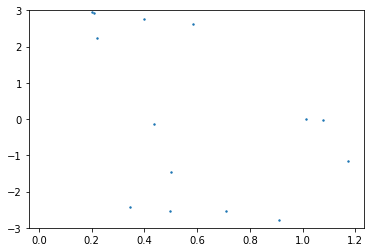

In [51]:
t=test.drop_duplicates('Seq')
t=t[t['SpecScatter']>0.15]
t=t[t['resid_ML'].abs()>0.15]
plt.scatter(t['specZ'],t['specZ_outlCoeff'],s=2)
plt.ylim(-3,3)

(-3, 3)

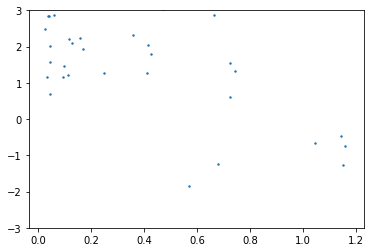

In [52]:
t=test.drop_duplicates('Seq')
t=t[t['SpecScatter']==0]
t=t[t['resid_ML'].abs()>0.15]
plt.scatter(t['specZ'],t['specZ_outlCoeff'],s=2)
plt.ylim(-3,3)